In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

In [2]:
# Define file paths
INPUT_DIR = Path("../../output/data")

MODEL_DIR = Path("../../output/models/alt_models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
print("\nLoading data from Pickle files...")
try:
    train_df = pd.read_pickle(INPUT_DIR / 'train_engineered.pkl')
    test_df = pd.read_pickle(INPUT_DIR / 'test_engineered.pkl')
    print(f"Train set loaded: {train_df.shape}")
    print(f"Test set loaded: {test_df.shape}")
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file .pkl. Hãy chạy Notebook 01 trước!")
    raise


Loading data from Pickle files...
Train set loaded: (80000, 24)
Test set loaded: (20000, 24)


In [4]:
target_col = 'target' 

X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]

X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]

In [5]:
bad_rate = y_train.mean()
print(f"\nTraining Class Balance (Bad Rate): {bad_rate:.2%}")


Training Class Balance (Bad Rate): 35.00%


In [6]:
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Calculated scale_pos_weight: {pos_weight:.2f}")

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    learning_rate=0.02,       # Học chậm để mô hình chắc chắn (Conservative)
    n_estimators=1500,        # Số lượng cây
    max_depth=5,              # Độ sâu vừa phải, tránh overfitting
    subsample=0.8,            # Lấy mẫu ngẫu nhiên 80% dòng
    colsample_bytree=0.8,     # Lấy mẫu ngẫu nhiên 80% cột
    scale_pos_weight=pos_weight,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=100
)

Calculated scale_pos_weight: 1.86


In [7]:
print("\nStarting training...")
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100  # In kết quả mỗi 100 vòng
)


Starting training...


[0]	validation_0-auc:0.99960	validation_1-auc:0.99954
[100]	validation_0-auc:0.99998	validation_1-auc:0.99996
[200]	validation_0-auc:0.99999	validation_1-auc:0.99998
[300]	validation_0-auc:1.00000	validation_1-auc:0.99998
[400]	validation_0-auc:1.00000	validation_1-auc:0.99999
[500]	validation_0-auc:1.00000	validation_1-auc:0.99999
[600]	validation_0-auc:1.00000	validation_1-auc:0.99999
[700]	validation_0-auc:1.00000	validation_1-auc:0.99999
[800]	validation_0-auc:1.00000	validation_1-auc:0.99999
[900]	validation_0-auc:1.00000	validation_1-auc:0.99999
[1000]	validation_0-auc:1.00000	validation_1-auc:0.99999
[1100]	validation_0-auc:1.00000	validation_1-auc:0.99999
[1182]	validation_0-auc:1.00000	validation_1-auc:0.99999


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,100
,enable_categorical,False
,eval_metric,'auc'


In [8]:
print("\n--- Model Evaluation ---")
# Dự báo xác suất (Probability of Bad)
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"Test AUC Score: {auc_score:.4f}")
if auc_score > 0.7:
    print("Result: GOOD performance for alternative data.")
elif auc_score > 0.6:
    print("Result: ACCEPTABLE performance.")
else:
    print("Result: NEEDS IMPROVEMENT.")


--- Model Evaluation ---


Test AUC Score: 1.0000
Result: GOOD performance for alternative data.


<Figure size 1200x800 with 0 Axes>

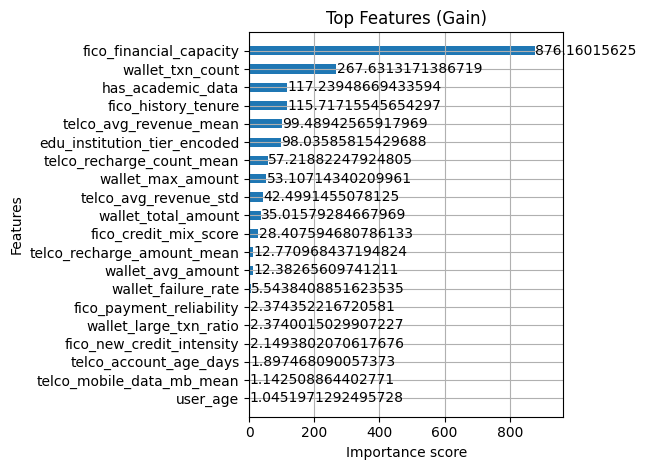

In [9]:
plt.figure(figsize=(12, 8))
xgb.plot_importance(model, max_num_features=20, height=0.5, importance_type='gain', title='Top Features (Gain)')
plt.tight_layout()
plt.show()

In [10]:
importance = model.get_booster().get_score(importance_type='gain')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 Important Features:")
for feat, score in sorted_importance[:10]:
    print(f"- {feat}: {score:.2f}")


Top 10 Important Features:
- fico_financial_capacity: 876.16
- wallet_txn_count: 267.63
- has_academic_data: 117.24
- fico_history_tenure: 115.72
- telco_avg_revenue_mean: 99.49
- edu_institution_tier_encoded: 98.04
- telco_recharge_count_mean: 57.22
- wallet_max_amount: 53.11
- telco_avg_revenue_std: 42.50
- wallet_total_amount: 35.02


In [11]:
print("\nFICO-Derived Features Performance:")
for feat, score in sorted_importance:
    if 'fico_' in feat:
        print(f" -> {feat}: {score:.2f}")


FICO-Derived Features Performance:
 -> fico_financial_capacity: 876.16
 -> fico_history_tenure: 115.72
 -> fico_credit_mix_score: 28.41
 -> fico_payment_reliability: 2.37
 -> fico_new_credit_intensity: 2.15


In [12]:
model_path = MODEL_DIR / 'xgb_alt_data_model.pkl'
joblib.dump(model, model_path)
print(f"\nModel saved successfully to: {model_path}")


Model saved successfully to: ..\..\output\models\alt_models\xgb_alt_data_model.pkl


In [13]:
joblib.dump(X_train.columns.tolist(), MODEL_DIR / 'model_features_list.pkl')
print(f"Feature list saved.")

Feature list saved.



--- TOP 10 FEATURE GÂY RA ROC 1.0 ---
                         feature  importance
17       fico_financial_capacity    0.477834
7               wallet_txn_count    0.145959
15             has_academic_data    0.063939
18           fico_history_tenure    0.063109
2         telco_avg_revenue_mean    0.054259
21  edu_institution_tier_encoded    0.053466
4      telco_recharge_count_mean    0.031206
9              wallet_max_amount    0.028963
3          telco_avg_revenue_std    0.023178
10           wallet_total_amount    0.019097


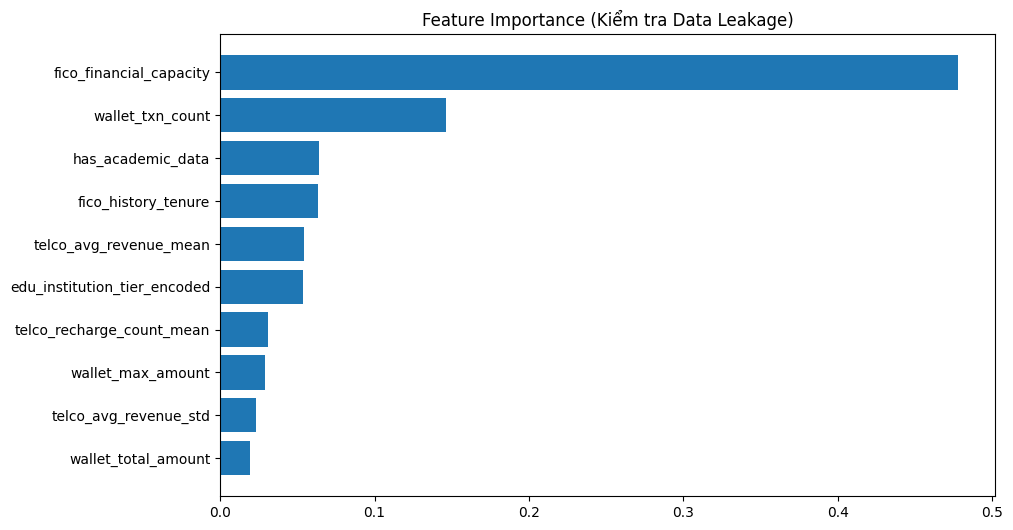


--- KIỂM TRA ĐỘ TƯƠNG QUAN feature vs target ---
fico_financial_capacity: -0.6092
wallet_txn_count: -0.7076
has_academic_data: -0.0885
fico_history_tenure: -0.1712
telco_avg_revenue_mean: -0.3361
edu_institution_tier_encoded: -0.0735
telco_recharge_count_mean: -0.1968
wallet_max_amount: -0.1666
telco_avg_revenue_std: -0.1813
wallet_total_amount: -0.1944


In [15]:
# 1. Xem Feature Importance (Biến nào quan trọng nhất?)
import matplotlib.pyplot as plt

# Lấy tầm quan trọng của các feature
importance = model.feature_importances_
feature_names = X_train.columns

# Tạo DataFrame để dễ nhìn
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importance})
feat_imp = feat_imp.sort_values('importance', ascending=False).head(10)

print("\n--- TOP 10 FEATURE GÂY RA ROC 1.0 ---")
print(feat_imp)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.gca().invert_yaxis()
plt.title("Feature Importance (Kiểm tra Data Leakage)")
plt.show()

# 2. Kiểm tra tương quan đơn biến với Target (Nếu > 0.9 là Leak)
print("\n--- KIỂM TRA ĐỘ TƯƠNG QUAN feature vs target ---")
for col in feat_imp['feature']:
    correlation = train_df[[col, 'target']].corr().iloc[0, 1]
    print(f"{col}: {correlation:.4f}")
    if abs(correlation) > 0.8:
        print(f"--> CẢNH BÁO: {col} có thể đang bị Rò rỉ dữ liệu!")